# Bareinboim Inequalities for MIMIC

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.stats import rankdata
import os
import glob
import re

exportdir='/data/localhost/taufiq/export-dir/'

In [2]:
import logging
logging.basicConfig(filename='bb-bounds.log', level=logging.INFO)

In [3]:
nra = 5
nr_reps = 1
col_bins_num = 5

In [4]:
MIMICtable = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5.csv')
MIMICtable = MIMICtable.sort_values(by=['icustay_id', 'bloc'], ignore_index=True)
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_1hourly,output_total,output_1hourly,cumulated_balance
0,1,3,7.245400e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.663900,599.999991,0.0,0.0,6267.0,0.0,9490.0,4705.0,-3223.0
1,2,3,7.245403e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.672340,339.999995,0.0,0.0,6267.0,10.0,14095.0,4605.0,-7818.0
2,3,3,7.245407e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.649789,339.999995,0.0,0.0,6277.0,20.0,18540.0,4445.0,-12243.0
3,4,3,7.245410e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.634454,339.999995,0.0,0.0,6297.0,20.0,22845.0,4305.0,-16528.0
4,5,3,7.245414e+09,0.0,17639.826435,0.0,0.0,0.0,0.0,1.0,...,0.0,0.645714,497.499993,0.0,0.0,6317.0,20.0,27050.0,4205.0,-20713.0


In [5]:
age_ranked = rankdata(MIMICtable['age'])/len(MIMICtable)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [MIMICtable.loc[age_bins==1, 'age'].median(), MIMICtable.loc[age_bins==2, 'age'].median(), MIMICtable.loc[age_bins==3, 'age'].median(), MIMICtable.loc[age_bins==4, 'age'].median()]
MIMICtable = MIMICtable.rename(columns={"age": "age_raw"})
MIMICtable['age'] = age_bins

In [6]:
os.chdir("/data/localhost/taufiq/biogears-data-5step/")
extension = '.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
biogears_data = pd.DataFrame()
for f in tqdm(all_filenames):
    if os.path.getsize(f) > 0:
        df = pd.read_csv(f)
        m = re.search('SimulateMIMIC_(.+?)_.csv', f)
        if m:
            icustay_id = m.group(1)
            df['icustay_id'] = int(icustay_id)
        biogears_data = biogears_data.append(df, ignore_index=True)
times = [600.02, 3600.02, 7200.02, 10800.02, 14400.02]
biogears_data = biogears_data[biogears_data['Time(s)'].isin(times)].reset_index(drop=True)
biogears_data.loc['icustay_id'] = biogears_data['icustay_id'].astype(int)

100%|██████████| 4993/4993 [02:16<00:00, 36.46it/s] 


In [7]:
icustayids = []
for icustay_id in biogears_data['icustay_id'].unique():
    if (biogears_data['icustay_id'] == icustay_id).sum() == 5:
        icustayids.append(icustay_id)
        
biogears_data = biogears_data[biogears_data['icustay_id'].isin(icustayids)].reset_index(drop=True)
biogears_data = biogears_data.sort_values(by=['icustay_id', 'Time(s)'], ignore_index=True)
biogears_data['bloc'] = np.arange(len(biogears_data))%5 + 1
len(biogears_data)

24965

In [8]:
column_mappings = {
    'Albumin-BloodConcentration(ug/mL)': 'Albumin',
    'ArterialCarbonDioxidePressure(mmHg)': 'paCO2',
    'ArterialOxygenPressure(mmHg)': 'paO2',
    'Bicarbonate-BloodConcentration(ug/mL)': 'HCO3',
    'ArterialBloodPH': 'Arterial_pH',
    'Calcium-BloodConcentration(ug/mL)': 'Calcium',
    'Chloride-BloodConcentration(ug/mL)': 'Chloride',
    'Creatinine-BloodConcentration(ug/mL)': 'Creatinine',
    'DiastolicArterialPressure(mmHg)': 'DiaBP',
    'Glucose-BloodConcentration(ug/mL)': 'Glucose',
    'Lactate-BloodConcentration(ug/mL)': 'Arterial_lactate',
    'MeanArterialPressure(mmHg)': 'MeanBP',
    'Potassium-BloodConcentration(ug/mL)': 'Potassium',
    'RespirationRate(1/min)': 'RR',
    'SkinTemperature(degC)': 'Temp_C',
    'Sodium-BloodConcentration(ug/mL)': 'Sodium',
    'SystolicArterialPressure(mmHg)': 'SysBP',
    'WhiteBloodCellCount(ct/uL)': 'WBC_count',
    'HeartRate(1/min)': 'HR'
}

biogears_rename = {}

for k, v in column_mappings.items():
    biogears_rename.update({k: f"{v}"})

biogears_data = biogears_data.rename(columns=biogears_rename)
biogears_data = biogears_data.merge(MIMICtable[['gender', 'age', 'Weight_kg', 'icustay_id', 'bloc']], left_on=['icustay_id', 'bloc'], right_on=['icustay_id', 'bloc'])

biogears_data.head()

,Time(s),HR,MeanBP,SysBP,DiaBP,CardiacOutput(mL/min),HemoglobinContent(g),CentralVenousPressure(mmHg),Hematocrit,Arterial_pH,...,Potassium,Chloride,Calcium,Magnesium-BloodConcentration,Albumin,icustay_id,bloc,gender,age,Weight_kg
0,600.02,80.0704,94.4514,121.415,65.1974,6966.54,726.611,4.36384,0.457689,7.39977,...,159.062,3730.66,93.2081,-1.$,44756.9,3.0,1,0.0,1.0,66.300000
1,3600.02,76.4121,95.4814,125.282,63.4174,7426.50,726.605,4.71677,0.432443,7.42003,...,157.600,3672.91,91.5462,-1.$,42168.6,3.0,2,0.0,1.0,78.699997
2,7200.02,75.3002,96.4199,126.567,63.8546,7496.60,726.600,4.88571,0.422476,7.42306,...,158.040,3647.92,90.5460,-1.$,41051.7,3.0,3,0.0,1.0,78.699997
3,10800.02,74.5508,96.0923,127.607,62.5015,7677.09,726.597,4.93964,0.418493,7.42634,...,158.185,3632.22,89.5818,-1.$,40597.6,3.0,4,0.0,1.0,78.699997
4,14400.02,74.3008,96.2715,127.919,62.5340,7699.90,726.595,5.06863,0.416189,7.42780,...,158.189,3617.94,88.6742,-1.$,40357.0,3.0,5,0.0,1.0,78.699997


In [9]:
logging.info('Creating action bins')
nact = nra**2
input_1hourly_nonzero = MIMICtable.loc[MIMICtable['input_1hourly']>0, 'input_1hourly']
iol_ranked = rankdata(input_1hourly_nonzero)/len(input_1hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_1hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_1hourly'].median(), MIMICtable.loc[io==2, 'input_1hourly'].median(), MIMICtable.loc[io==3, 'input_1hourly'].median(), MIMICtable.loc[io==4, 'input_1hourly'].median(), MIMICtable.loc[io==5, 'input_1hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

In [10]:
def get_trajec_actions(trajectories, column):
    trajec_actions = pd.DataFrame()
    for index, row in trajectories.iterrows():
        if row['t'] == 0 and index > 0:
            trajec_actions = trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
            age = row['age']
        elif index == 0:
            age = row['age']
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
        else:
            age = row['age']
            actions.append(row['A_t'])
            col_traj.append(row[column])
            gender = row['gender']

    trajec_actions = trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
    return trajec_actions

In [11]:
def get_sim_trajec_actions(sim_trajecs, column):
    sim_trajec_actions = pd.DataFrame()
    for index, row in sim_trajecs.iterrows():
        if row['t'] == 0 and index > 0:
            sim_trajec_actions = sim_trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
            age = row['age']
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
        elif index == 0:
            age = row['age']
            actions = [row['A_t']]
            col_traj = [row[column]]
            gender = row['gender']
        else:
            age = row['age']
            actions.append(row['A_t'])
            col_traj.append(row[column])
            gender = row['gender']

    sim_trajec_actions = sim_trajec_actions.append({'actions': actions, 'gender': gender, 'age': age, column: col_traj}, ignore_index=True)
    sim_trajec_actions['icustay_id'] = sim_trajecs['icustay_id'].unique()
    return sim_trajec_actions

In [12]:
from ast import literal_eval


def find_elements(series, element):
    return series.apply(lambda x: literal_eval(str(x)) == element)

def find_elements_starting_with(series, element):
    return series.apply(lambda x: literal_eval(str(x))[:len(element)] == element)

def find_elements_containing(series, element):
    return series.apply(lambda x: literal_eval(str(element)) in literal_eval(str(x)))

In [13]:
def compute_probs(trajec_actions, column, column_v, gender, age, actions):
    prob_a_den = 0
    gamma = []
    df = pd.DataFrame()
    df[[f'{column}_0',f'{column}_1',f'{column}_2',f'{column}_3']] = pd.DataFrame(trajec_actions[column].tolist(), index= trajec_actions.index)
    df[[f'a_0',f'a_1',f'a_2',f'a_3']] = pd.DataFrame(trajec_actions['actions'].tolist(), index= trajec_actions.index)
    trajecs_filtered = (trajec_actions['gender'] == gender) & (trajec_actions['age'] == age)
    num_term = trajecs_filtered
    den_term_1 = trajecs_filtered
    den_term_2 = trajecs_filtered
    for i in range(len(actions)):
        num_term = num_term & (df[f'{column}_{i}'] == column_v[i]) & (df[f'a_{i}'] == actions[i])
        prob_a_num = num_term.sum()
        if i == 0:
            den_term_1 = den_term_1 & (df[f'{column}_{i}'] == column_v[i])
            prob_a_den += den_term_1.sum()
        else:
            den_term_1 = den_term_1 & (df[f'{column}_{i}'] == column_v[i]) & (df[f'a_{i-1}'] == actions[i-1])
            den_term_2 = den_term_2 & (df[f'{column}_{i-1}'] == column_v[i-1]) & (df[f'a_{i-1}'] == actions[i-1])
            prob_a_den += den_term_1.sum() - den_term_2.sum()
        if prob_a_num == 0:
            gamma.append(0)
        else:
            gamma.append(prob_a_num/prob_a_den)
    return gamma

In [14]:
from sklearn.utils import resample
def bootstrap_distribution(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, n_iter=100):
    df = pd.DataFrame()
    max_y = trajec_actions.loc[find_elements(trajec_actions['gender'], gender) & find_elements(trajec_actions['age'], age) & find_elements_containing(trajec_actions[col], max(column_v)), f'{col}_raw'].max()
    min_y = trajec_actions.loc[find_elements(trajec_actions['gender'], gender) & find_elements(trajec_actions['age'], age) & find_elements_containing(trajec_actions[col], min(column_v)), f'{col}_raw'].min()
    sim_filtered = sim_trajec_actions[find_elements_starting_with(sim_trajec_actions[col], column_v) & find_elements(sim_trajec_actions['gender'], gender) & find_elements(sim_trajec_actions['age'], age) & find_elements_starting_with(sim_trajec_actions['actions'], action)].copy()
    real_filtered = trajec_actions[find_elements(trajec_actions[col], column_v) & find_elements(trajec_actions['gender'], gender) & find_elements(sim_trajec_actions['age'], age) & find_elements_starting_with(trajec_actions['actions'], action)].copy()
    if len(real_filtered) > 1 and len(sim_filtered) > 1:
        for i in range(n_iter):
            real_train = resample(real_filtered, n_samples=len(real_filtered))
            exp_y = real_train[f'{col}_raw'].mean()
            prob = real_train['prob_a'].max()
            sim_train = resample(sim_filtered, n_samples=len(sim_filtered))
            exp_y_sim = sim_train[f'{col}_raw'].mean()
            df = df.append({'Exp_y': exp_y, 'UB': prob*exp_y + (1-prob)*max_y, 'LB': prob*exp_y + (1-prob)*min_y, 'Sim_exp_y': exp_y_sim, 'max_y':max_y, 'min_y': min_y}, ignore_index=True)
        return df
    return None


In [15]:
from sklearn.utils import resample
def bootstrap_distribution_deprecated(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, n_iter=100, i=3):
    global biogears_data, MIMICtable
    biogears_data = biogears_data.rename(columns={col: f'{col}_raw'})
    MIMICtable = MIMICtable.rename(columns={col: f'{col}_raw'})
    sim = sim_trajec_actions[['actions', 'gender', 'age', 'icustay_id', col]].merge(biogears_data[biogears_data['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    obs_data = trajec_actions[['actions', 'gender', 'age', 'icustay_id', col, f'prob_a_{i}']].merge(MIMICtable[MIMICtable['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    df = pd.DataFrame()
    max_y = obs_data.loc[find_elements(obs_data['gender'], gender) & find_elements(obs_data['age'], age) & find_elements_containing(obs_data[col], max(column_v)), f'{col}_raw'].max()
    min_y = obs_data.loc[find_elements(obs_data['gender'], gender) & find_elements(obs_data['age'], age) & find_elements_containing(obs_data[col], min(column_v)), f'{col}_raw'].min()
#     sim_filtered = sim[find_elements(sim['gender'], gender) & find_elements(sim['age'], age) & find_elements_starting_with(sim[col], column_v) & find_elements_starting_with(sim['actions'], action)].copy()
#     real_filtered = obs_data[find_elements(obs_data['gender'], gender) & find_elements(obs_data['age'], age) & find_elements_starting_with(obs_data[col], column_v) & find_elements_starting_with(obs_data['actions'], action)].copy()
    sim_filtered = sim[find_elements(sim['gender'], gender) & find_elements(sim['age'], age) & find_elements_starting_with(sim[col], column_v[:i+1]) & find_elements_starting_with(sim['actions'], action[:i+1])].copy()
    real_filtered = obs_data[find_elements(obs_data['gender'], gender) & find_elements(obs_data['age'], age) & find_elements_starting_with(obs_data[col], column_v[:i+1]) & find_elements_starting_with(obs_data['actions'], action[:i+1])].copy()
    if len(real_filtered) > 1 and len(sim_filtered) > 1:
        for j in range(n_iter):
            real_train = resample(real_filtered, n_samples=len(real_filtered))
            exp_y = real_train[f'{col}_raw'].mean()
            prob = real_train[f'prob_a_{i}'].max()
            sim_train = resample(sim_filtered, n_samples=len(sim_filtered))
            exp_y_sim = sim_train[f'{col}_raw'].mean()
            df = df.append({'Exp_y': exp_y, 'UB': prob*exp_y + (1-prob)*max_y, 'LB': prob*exp_y + (1-prob)*min_y, 'Sim_exp_y': exp_y_sim, 'max_y':max_y, 'min_y': min_y}, ignore_index=True)
        return df
    return None

In [16]:
from sklearn.utils import resample
def bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, n_iter=100, i=3):
    global biogears_data, MIMICtable
    biogears_data = biogears_data.rename(columns={col: f'{col}_raw'})
    MIMICtable = MIMICtable.rename(columns={col: f'{col}_raw'})
    sim = sim_trajec_actions[['actions', 'gender', 'age', 'icustay_id', col]].merge(biogears_data[biogears_data['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    obs_data = trajec_actions[['actions', 'gender', 'age', 'icustay_id', col]].merge(MIMICtable[MIMICtable['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    sim.loc[:,f'{col}_tuple'] = sim[col].apply(tuple)
    sim.loc[:,f'actions_tuple'] = sim['actions'].apply(tuple)
    obs_data.loc[:,f'{col}_tuple'] = obs_data[col].apply(tuple)
    obs_data.loc[:,f'actions_tuple'] = obs_data['actions'].apply(tuple)
    df = pd.DataFrame()
    max_y = obs_data.loc[(obs_data['gender'] == gender) & (obs_data['age'] == age) & find_elements_containing(obs_data[col], max(column_v)), f'{col}_raw'].max()
    min_y = obs_data.loc[(obs_data['gender'] == gender) & (obs_data['age'] == age) & find_elements_containing(obs_data[col], min(column_v)), f'{col}_raw'].min()
    sim_filtered = sim[(sim['gender'] == gender) & (sim['age'] == age) & (sim[f'{col}_tuple']==tuple(column_v)) & (sim['actions_tuple'] == tuple(action))].copy()
    real_filtered = obs_data[(obs_data['gender'] == gender) & (obs_data['age'] == age) & (obs_data[f'{col}_tuple']==tuple(column_v)) & (obs_data['actions_tuple'] == tuple(action))].copy()
    if len(real_filtered) > 1 and len(sim_filtered) > 1:
        for j in range(n_iter):
            obs_resampled = resample(obs_data, n_samples=len(obs_data))
            probs = compute_probs(obs_resampled, col, column_v, gender, age, action)
            prob = probs[i]
            real_train = resample(real_filtered, n_samples=len(real_filtered))
            exp_y = real_train[f'{col}_raw'].mean()
            sim_train = resample(sim_filtered, n_samples=len(sim_filtered))
            exp_y_sim = sim_train[f'{col}_raw'].mean()
            df = df.append({'Exp_y': exp_y, 'UB': prob*exp_y + (1-prob)*max_y, 'LB': prob*exp_y + (1-prob)*min_y, 'Sim_exp_y': exp_y_sim, 'max_y':max_y, 'min_y': min_y}, ignore_index=True)
        return df
    return None

In [17]:
# pvals.head()

In [18]:
import matplotlib.pyplot as plt
def plot_bootstrapp_distributions(col, gender, age, action, column_v):
    global trajec_actions, sim_trajec_actions
    df = bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions)
    plt.hist(df['Exp_y'], bins=10, color='grey', label='Exp(y)')
    ub_lim = df['UB'].mean() + 1.96*df['UB'].std()
    lb_lim = df['LB'].mean() - 1.96*df['LB'].std()
    plt.axvspan(lb_lim, ub_lim, alpha=0.1, color='purple')
    plt.hist(df['Sim_exp_y'], bins=10, color='pink', label='Simulated Exp(y)')
    plt.legend()
    plt.show()

In [19]:
import matplotlib.pyplot as plt

column_names_unit = {
    'Albumin': 'Albumin Blood Concentration (mg/L)',
#     'paCO2': 'Arterial $CO_2$ Pressure (mmHg)',
#     'paO2': 'Arterial $O_2$ Pressure (mmHg)',
    'HCO3': 'Bicarbonate Blood Concentration (mg/L)',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration (mg/L)',
    'Calcium': 'Calcium Blood Concentration (mg/L)',
#     'Chloride': 'Chloride Blood Concentration (mg/L)',
    'Creatinine': 'Creatinine Blood Concentration (mg/L)',
    'DiaBP': 'Diastolic Arterial Pressure (mmHg)',
    'SysBP': 'Systolic Arterial Pressure (mmHg)',
    'Glucose': 'Glucose Blood Concentration (mg/L)',
    'MeanBP': 'Mean Arterial Pressure (mmHg)',
    'Potassium': 'Potassium Blood Concentration (mg/L)',
    'RR': 'Respiration Rate (1/min)',
    'Temp_C': 'Skin Temperature (C)',
#     'Sodium': 'Sodium Blood Concentration (mg/L)',
    'WBC_count': 'White Blood Cell Count (ct/uL)',
    'HR': 'Heart Rate (1/min)'
}

In [20]:
def plot_bounds_bootstrap(col, gender, age, action, column_v):
#     global trajec_actions, sim_trajec_actions, column_names_unit
#     rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col}.csv", converters={'actions': eval, col: eval})
    trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col}.csv", converters={'actions': eval, col: eval})
    sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col}.csv", converters={'actions': eval, col:eval})
    lb = []
    ub = []
    sim_mean, sim_lb, sim_ub = [], [], []
    max_vals, min_vals = [], []
    probs = []
    for i in range(len(action)):
        df = bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, n_iter=100, i=i)
        lb.append(df['LB'].mean() - 1.96*df['LB'].std())
        ub.append(df['UB'].mean() + 1.96*df['UB'].std())
        sim_ub.append(df['Sim_exp_y'].mean() + 1.96*df['Sim_exp_y'].std())
        sim_lb.append(df['Sim_exp_y'].mean() - 1.96*df['Sim_exp_y'].std())
        sim_mean.append(df['Sim_exp_y'].mean())
        max_vals.append(df['max_y'].max())
        min_vals.append(df['min_y'].min())
    plt.figure(figsize=(12,8)),
    plt.plot(range(1,5), sim_mean, '-', color='gray')
    plt.xlabel('Time (hr)', fontsize=13)
    plt.ylabel(column_names_unit[col], fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.fill_between(range(1,5), sim_ub, sim_lb, color='navy', alpha=0.4, label='Simulated')
    plt.fill_between(range(1,5), lb, ub, color='purple', alpha=0.4, label='Bareinboim bounds')
    plt.fill_between(range(1,5), min_vals, max_vals, color='pink', alpha=0.5, label='Max-min bounds')
    plt.legend(fontsize=13)
    plt.grid(True)
    plt.show()

In [21]:
import scipy.stats as st

def rejected_hypotheses_bootstrap(col, trajec_actions, sim_trajec_actions):
    state_actions = trajec_actions[['gender', 'age', 'actions', col]].copy()
    state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
    state_actions.loc[:,'s'] = state_actions[col].apply(tuple)
    state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
    total_hypotheses = len(state_actions)
    p_values = pd.DataFrame()
    for index, row in state_actions.iterrows():
        df = bootstrap_distribution(col, row['gender'], row['age'], row['actions'], row[col], trajec_actions, sim_trajec_actions)
        if df is not None:
            sigma_ub = (df['UB']-df['Sim_exp_y']).var()
            exp_ub = (df['UB']-df['Sim_exp_y']).mean()
            p_ub = st.norm.cdf(exp_ub/np.sqrt(sigma_ub))
            sigma_lb = (df['Sim_exp_y']-df['LB']).var()
            exp_lb = (df['Sim_exp_y']-df['LB']).mean()
            p_lb = st.norm.cdf(exp_lb/np.sqrt(sigma_lb))
            p_values = p_values.append({'gender': row['gender'], 'age': row['age'], 'actions': row['actions'], col: row[col], 'p_lb': p_lb, 'p_ub': p_ub}, ignore_index=True)
    rej_hyps = p_values[(p_values['p_lb']<0.05/total_hypotheses) ^ (p_values['p_ub']<0.05/total_hypotheses)].copy()
    for index, row in rej_hyps.iterrows():
        rej_hyps.loc[index, 'n_real'] = (find_elements(trajec_actions['gender'], row['gender']) & find_elements(trajec_actions['age'], row['age']) & find_elements(trajec_actions['actions'], row['actions']) & find_elements(trajec_actions[col], row[col])).sum()
        rej_hyps.loc[index, 'n_sim'] = (find_elements(sim_trajec_actions['gender'], row['gender']) & find_elements(sim_trajec_actions['age'], row['age']) & find_elements(sim_trajec_actions['actions'], row['actions']) & find_elements(sim_trajec_actions[col], row[col])).sum()
    return len(rej_hyps), p_values, rej_hyps


In [22]:
column_names_dict = {
    'Albumin': 'Albumin Blood Concentration',
#     'paCO2': 'Arterial $CO_2$ Pressure',
#     'paO2': 'Arterial $O_2$ Pressure',
    'HCO3': 'Bicarbonate Blood Concentration',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium Blood Concentration',
    'Chloride': 'Chloride Blood Concentration',
    'Creatinine': 'Creatinine Blood Concentration',
    'DiaBP': 'Diastolic Arterial Pressure',
    'SysBP': 'Systolic Arterial Pressure',
    'Glucose': 'Glucose Blood Concentration',
    'MeanBP': 'Mean Arterial Pressure',
    'Potassium': 'Potassium Blood Concentration',
    'RR': 'Respiration Rate',
    'Temp_C': 'Skin Temperature',
    'Sodium': 'Sodium Blood Concentration',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'Heart Rate'
}

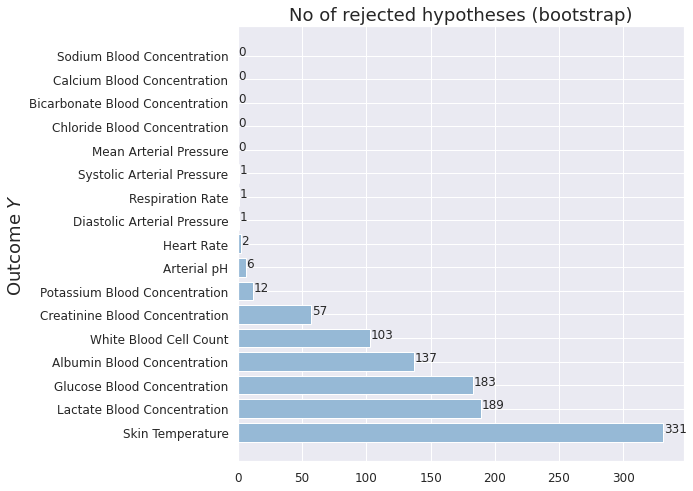

In [54]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

hyp_test_dir = "/data/localhost/taufiq/bootstrap-colbins-updated/biogears_trajecs_sofa_colbins_3/"

rejected_hyp_bootstrap = pd.read_csv(f"{hyp_test_dir}/rej_hyp_nums.csv")
for index, row in rejected_hyp_bootstrap.iterrows():
    rejected_hyp_bootstrap.at[index, 'Outcome Y'] = column_names_dict[row['Outcome Y']]

fig, ax = plt.subplots(figsize=(8,8))

rejected_hyp_bootstrap.sort_values('# rejected hypotheses', ascending=False, inplace=True)
ax.barh(rejected_hyp_bootstrap['Outcome Y'],rejected_hyp_bootstrap['# rejected hypotheses'],  color='#96b9d6')
y = rejected_hyp_bootstrap['# rejected hypotheses']
for i, v in enumerate(y):
    ax.text(v + 0.5, i, str(v), fontsize=12)

plt.title('No of rejected hypotheses (bootstrap)')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.show()

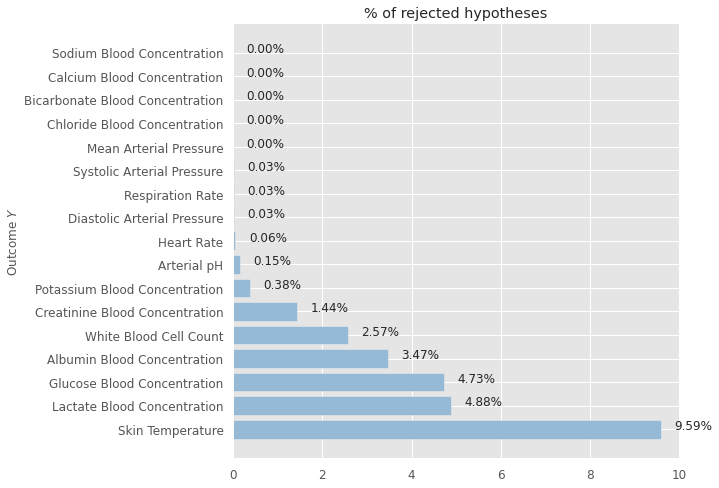

In [55]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# hyp_test_dir = "/data/localhost/taufiq/hyp-test-dir"

fig, ax = plt.subplots(figsize=(8,8))

rejected_hyp_bootstrap.sort_values('# rejected hypotheses', ascending=False, inplace=True)
ax.barh(rejected_hyp_bootstrap['Outcome Y'],rejected_hyp_bootstrap['# rejected hypotheses']/rejected_hyp_bootstrap['Total # hypotheses']*100,  color='#96b9d6')
y = rejected_hyp_bootstrap['# rejected hypotheses']/rejected_hyp_bootstrap['Total # hypotheses']*100
for i, v in enumerate(y):
    ax.text(v + 0.3, i, "{:.2f}%".format(v), fontsize=12)

plt.title('% of rejected hypotheses')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.xlim([0,10])
plt.show()

In [56]:
rejected_hyp_bootstrap

,Outcome Y,# rejected hypotheses,Total # hypotheses,SOFA bin
6,Skin Temperature,331,3450,None
9,Lactate Blood Concentration,189,3876,None
10,Glucose Blood Concentration,183,3872,None
5,Albumin Blood Concentration,137,3947,None
13,White Blood Cell Count,103,4009,None
15,Creatinine Blood Concentration,57,3959,None
4,Potassium Blood Concentration,12,3141,None
1,Arterial pH,6,3954,None
7,Heart Rate,2,3527,None
16,Diastolic Arterial Pressure,1,3871,None


In [57]:
col_name = "Temp_C"

rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})

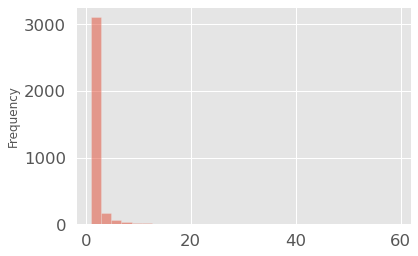

In [64]:
state_actions_unique = trajec_actions[['age','gender']].copy()
state_actions_unique.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
state_actions_unique.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
state_actions_unique = state_actions_unique.groupby(['gender', 'age', 'a', 's']).size()
state_actions_unique.plot.hist(bins=30, alpha=0.5)

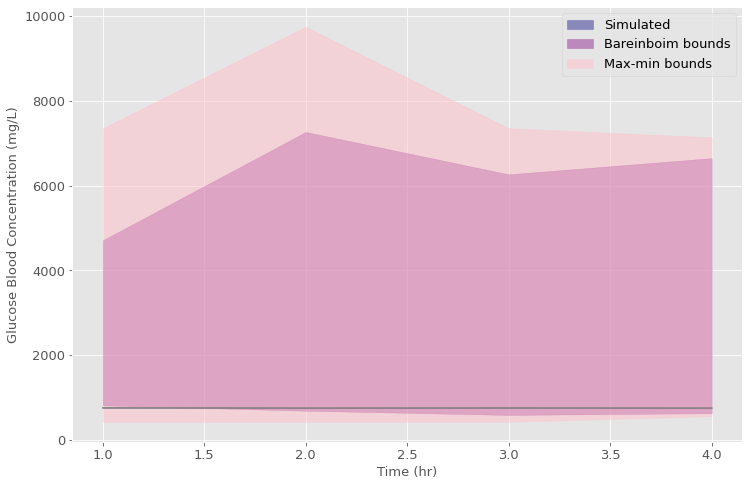

In [28]:
plot_bounds_bootstrap('Glucose', 1, 4, [1, 1, 1, 1], [2,2,2,2])

In [29]:
def rej_hyps_age_group(col, gender, age):
    state_actions = trajec_actions[['gender', 'age', 'actions', col]].copy()
    state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
    state_actions.loc[:,'s'] = state_actions[col].apply(tuple)
    state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
    total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
    rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    return rej_hyps_num/total_hyp*100

In [30]:
rej_hyps_age_group(col_name, 1, 1)

0.0

In [31]:
ages = []
for i in range(1, 4):
    age_min = str(int(MIMICtable.loc[MIMICtable['age']==i, 'age_raw'].min()/365))
    age_max = str(int(MIMICtable.loc[MIMICtable['age']==i+1, 'age_raw'].min()/365))
    ages.append(f'{age_min}-{age_max}')
ages.append(f'>{age_max}')

In [32]:
rej_hyps_age = pd.DataFrame()
gend = ['male', 'female']
for gender in [0,1]:
    for age in [1,2,3,4]:
        rh = rej_hyps_age_group(col_name, gender, age)
        rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)

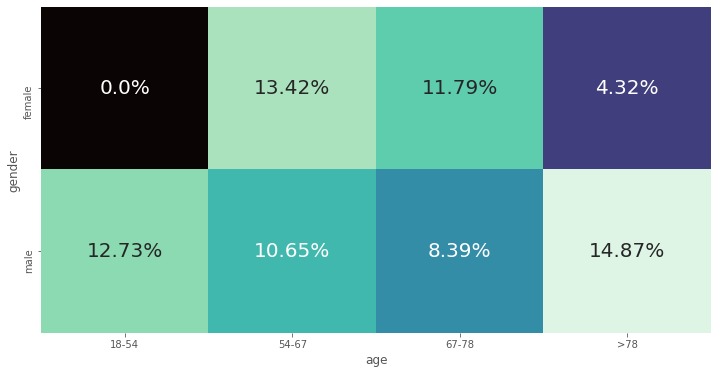

In [33]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(12,6))
rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
sns.set(font_scale=1.5)
labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
for i in range(len(labels)):
    for j in range(len(labels[0])):
        labels[i][j] += '%'
sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs, annot_kws={"fontsize":20}, cbar=False)

# Divide by severity

In [34]:
import numpy as np
def generate_dataframe_by_severity():
    df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
#         print("Rej hyps", len(rej_hyps))
#         print("Trajec actions", len(trajec_actions))
        state_actions_unique = trajec_actions.copy()
        state_actions_unique.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
        state_actions_unique.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
        state_actions_unique = state_actions_unique.drop_duplicates(['gender', 'age', 'a', 's'])
        for index, row in state_actions_unique.iterrows():
            if np.median(row['s']) <= 1:
                state_actions_unique.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row['s']) <= 2:
                state_actions_unique.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row['s']) <= 3:
                state_actions_unique.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row['s']) <= 4:
                state_actions_unique.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row['s']) <= 5:
                state_actions_unique.loc[index, 'Outcome severity'] = 'very high'
                
        for index, row in rej_hyps.iterrows():
#             print(np.median(row[col_name]))
            if np.median(row[col_name]) <= 1:
                rej_hyps.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row[col_name]) <= 2:
                rej_hyps.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row[col_name]) <= 3:
                rej_hyps.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row[col_name]) <= 4:
                rej_hyps.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row[col_name]) <= 5:
                rej_hyps.loc[index, 'Outcome severity'] = 'very high'
        for severity in ['extremely low', 'low', 'medium', 'high', 'very high']:
            if len(rej_hyps) > 0:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': (rej_hyps['Outcome severity']==severity).sum(), 'Total # hypotheses': (state_actions_unique['Outcome severity']==severity).sum(), '% rejected': (rej_hyps['Outcome severity']==severity).sum()/(state_actions_unique['Outcome severity']==severity).sum()*100}, ignore_index=True)
            else:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': 0, 'Total # hypotheses': (state_actions_unique['Outcome severity']==severity).sum(), '% rejected': 0}, ignore_index=True)
    return df

In [35]:
df = generate_dataframe_by_severity()

  0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-34-02c417f1802c>:39: RuntimeWarning: invalid value encountered in long_scalars
  df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': (rej_hyps['Outcome severity']==severity).sum(), 'Total # hypotheses': (state_actions_unique['Outcome severity']==severity).sum(), '% rejected': (rej_hyps['Outcome severity']==severity).sum()/(state_actions_unique['Outcome severity']==severity).sum()*100}, ignore_index=True)
100%|██████████| 15/15 [00:22<00:00,  1.47s/it]


In [36]:
df = df.pivot_table(index=["Outcome"], columns="Outcome severity", values="% rejected", aggfunc=np.max)
df.style.format('{:.1f}').background_gradient(cmap ='viridis')

Outcome severity,extremely low,high,low,medium,very high
Outcome,,,,,
Albumin,5.5,nan,4.5,0.4,nan
Arterial_lactate,0.8,nan,5.1,7.3,nan
Arterial_pH,0.4,nan,0.1,0.0,nan
Calcium,0.0,0.0,0.0,0.0,0.0
Creatinine,0.4,nan,0.3,3.6,nan
DiaBP,0.0,nan,0.0,0.1,nan
Glucose,0.8,nan,4.4,7.8,nan
HCO3,0.0,0.0,0.0,0.0,0.0
HR,0.0,nan,0.0,0.2,nan


# Only hypotheses with $n_{obs}\geq 10$ 

In [37]:
def filtered_rejected_hypotheses():
    df = pd.DataFrame()
    all_rej_hyps = pd.DataFrame()
    all_hyps = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        if len(rej_hyps)>0:
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)&(rej_hyps['n_sim']>=10)]
            state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
            state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
            state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
            trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
            trajec_actions.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
            sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
            sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col_name].apply(tuple)
            state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
            for index, row in state_actions.iterrows():
                state_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                state_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
            state_actions = state_actions[(state_actions['n_real']>=10)&(state_actions['n_sim']>=10)]
            df = df.append({'Outcome Y': col_name, '# rejected hypotheses': len(rej_hyps), 'Total # hypotheses': len(state_actions)}, ignore_index=True)
        rej_hyps['col_name'] = col_name
        state_actions['col_name'] = col_name
        all_rej_hyps = all_rej_hyps.append(rej_hyps, ignore_index=True)
        all_hyps = all_hyps.append(state_actions, ignore_index=True)
    return df, all_rej_hyps, all_hyps

In [38]:
df, all_rej_hyps, all_hyps = filtered_rejected_hypotheses()

100%|██████████| 15/15 [02:16<00:00,  9.09s/it]


In [39]:
df

,# rejected hypotheses,Outcome Y,Total # hypotheses
0,16.0,Albumin,31.0
1,2.0,Arterial_pH,30.0
2,17.0,Arterial_lactate,31.0
3,9.0,Creatinine,28.0
4,0.0,DiaBP,30.0
5,0.0,SysBP,45.0
6,15.0,Glucose,33.0
7,3.0,Potassium,54.0
8,0.0,RR,37.0
9,40.0,Temp_C,50.0


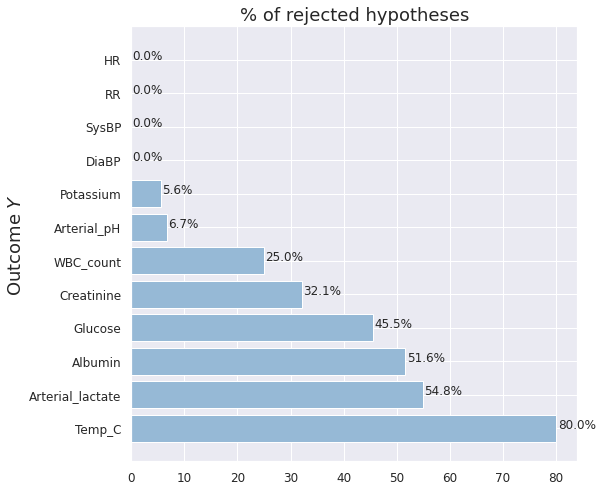

In [40]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
df['% rejected'] = df['# rejected hypotheses']/df['Total # hypotheses']*100
df.sort_values('% rejected', ascending=False, inplace=True)
ax.barh(df['Outcome Y'],df['% rejected'],  color='#96b9d6')
y = df['% rejected']
for i, v in enumerate(y):
    ax.text(v + 0.3, i, "{:.1f}%".format(v), fontsize=12)

plt.title('% of rejected hypotheses')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.show()

In [41]:
def rej_hyps_age_group(col, gender, age):
    state_actions = all_hyps[all_hyps['col_name']==col]
    rej_hyps = all_rej_hyps[all_rej_hyps['col_name']==col]
    total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
    rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    return rej_hyps_num/total_hyp*100

In [42]:
def plot_heatmap(col_name):
    rej_hyps_age = pd.DataFrame()
    gend = ['male', 'female']
    for gender in [0,1]:
        for age in [1,2,3,4]:
            rh = rej_hyps_age_group(col_name, gender, age)
            rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)
    fig, axs = plt.subplots(1, figsize=(12,6))
    rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
    sns.set(font_scale=1.5)
    labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
    for i in range(len(labels)):
        for j in range(len(labels[0])):
            labels[i][j] += '%'
    sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs, annot_kws={"fontsize":20}, cbar=False)

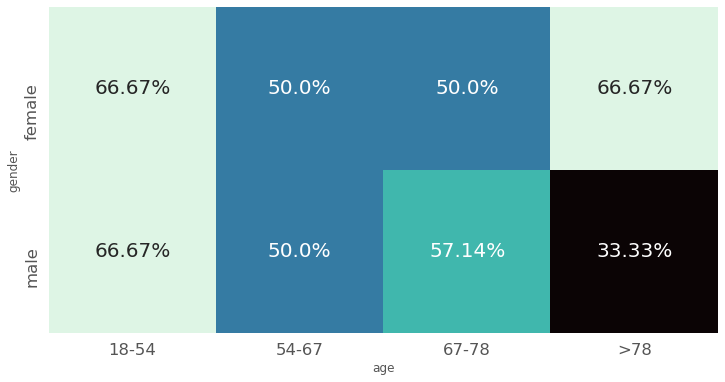

In [43]:
plot_heatmap('Arterial_lactate')

In [44]:
all_rej_hyps[all_rej_hyps['col_name']=='Temp_C']

,Unnamed: 0,Albumin,actions,age,gender,p,n_real,n_sim,col_name,HCO3,...,Creatinine,DiaBP,SysBP,Glucose,MeanBP,Potassium,RR,Temp_C,WBC_count,HR
62,1,NaN,"[1.0, 1.0, 1.0, 1.0]",2.0,0.0,0.0,56.0,44.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.0, 2.0, 2.0, 2.0]",NaN,NaN
63,4,NaN,"[3.0, 3.0, 3.0, 3.0]",2.0,0.0,0.0,13.0,12.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.0, 2.0, 2.0, 2.0]",NaN,NaN
64,13,NaN,"[1.0, 1.0, 1.0, 1.0]",3.0,0.0,0.0,55.0,47.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.0, 2.0, 2.0, 2.0]",NaN,NaN
65,14,NaN,"[1.0, 1.0, 1.0, 1.0]",4.0,0.0,0.0,50.0,40.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.0, 1.0, 1.0, 1.0]",NaN,NaN
66,15,NaN,"[1.0, 1.0, 1.0, 1.0]",4.0,0.0,0.0,41.0,29.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.0, 2.0, 2.0, 2.0]",NaN,NaN
67,29,NaN,"[1.0, 1.0, 1.0, 1.0]",2.0,0.0,0.0,44.0,34.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1.0, 1.0, 1.0, 1.0]",NaN,NaN
68,42,NaN,"[4.0, 4.0, 4.0, 4.0]",3.0,0.0,0.0,12.0,10.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[3.0, 3.0, 3.0, 3.0]",NaN,NaN
69,46,NaN,"[3.0, 3.0, 3.0, 3.0]",3.0,0.0,0.0,19.0,18.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.0, 2.0, 2.0, 2.0]",NaN,NaN
70,50,NaN,"[5.0, 5.0, 5.0, 5.0]",1.0,0.0,0.0,15.0,11.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[3.0, 3.0, 3.0, 3.0]",NaN,NaN
71,53,NaN,"[3.0, 3.0, 3.0, 3.0]",1.0,0.0,0.0,16.0,13.0,Temp_C,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2.0, 2.0, 2.0, 2.0]",NaN,NaN


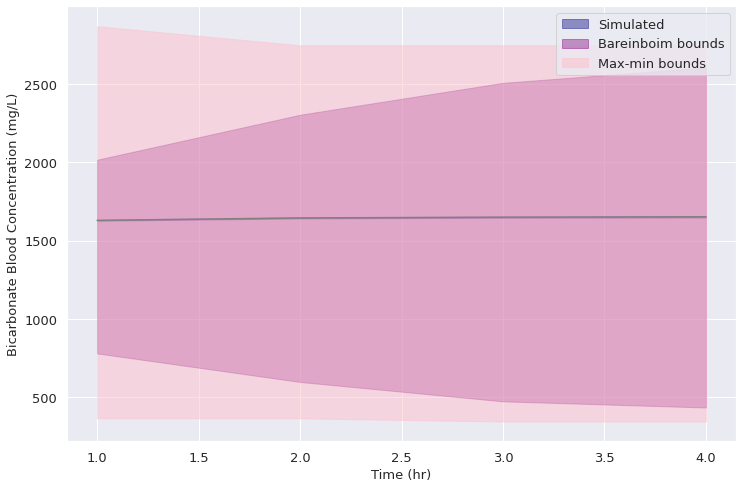

In [45]:
plot_bounds_bootstrap('HCO3', 1, 4, [1, 1, 1, 1], [1,1,1,1])

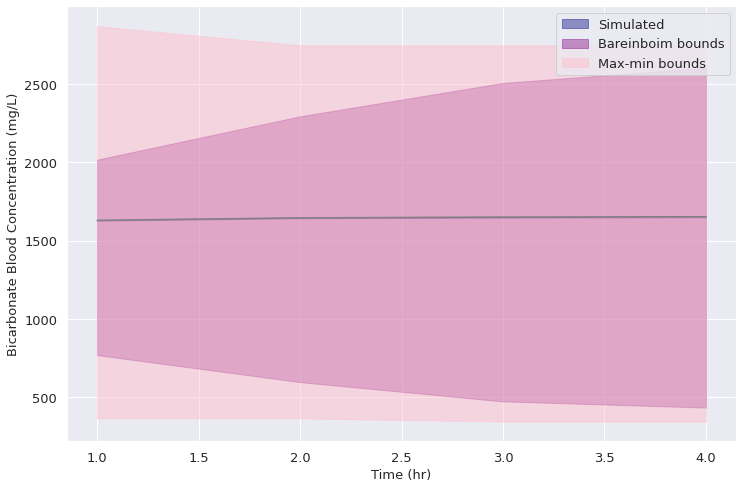

In [46]:
plot_bounds_bootstrap('HCO3', 1, 4, [1, 1, 1, 1], [1,1,1,1])

In [47]:
def generate_violin_plots():
    combined_df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})

        rej_hyps_filtered = all_rej_hyps[all_rej_hyps['col_name']==col_name].copy()
        rej_hyps_filtered.loc[:,'s'] = rej_hyps_filtered[col_name].apply(tuple)
        rej_hyps_filtered.loc[:,'a'] = rej_hyps_filtered['actions'].apply(tuple)

        state_actions = trajec_actions.copy()
        state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
        state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
        rej_hyps_filtered = rej_hyps_filtered.merge(state_actions[['gender', 'age', 's', 'a' ,'prob_a_0', 'prob_a_1', 'prob_a_2', 'prob_a_3', 'prob_a']], left_on=['gender', 'age', 's', 'a'], right_on=['gender', 'age', 's', 'a'])

        all_hyps_filtered = all_hyps[all_hyps['col_name']==col_name].copy()
        all_hyps_filtered.loc[:,'s'] = all_hyps_filtered[col_name].apply(tuple)
        all_hyps_filtered.loc[:,'a'] = all_hyps_filtered['actions'].apply(tuple)
        all_hyps_filtered = all_hyps_filtered.merge(state_actions[['gender', 'age', 's', 'a' ,'prob_a_0', 'prob_a_1', 'prob_a_2', 'prob_a_3', 'prob_a']], left_on=['gender', 'age', 's', 'a'], right_on=['gender', 'age', 's', 'a'])

        non_rej_hyps = pd.DataFrame()
        for index, row in all_hyps_filtered.iterrows():
             if ((rej_hyps_filtered['gender']==row['gender']) & (rej_hyps_filtered['age']==row['age']) & (rej_hyps_filtered['s']==row['s']) & (rej_hyps_filtered['a']==row['a'])).sum() == 0:
                    non_rej_hyps = non_rej_hyps.append(row, ignore_index=True)
                    
        non_rej_hyps['Outcome'] = f'{col_name}'+'$_{a}$'
        rej_hyps_filtered['Outcome'] = f'{col_name}' + '$_{r}$'
        combined = non_rej_hyps[['Outcome', 'prob_a']].merge(rej_hyps_filtered[['Outcome', 'prob_a']], left_on=['Outcome', 'prob_a'], right_on=['Outcome', 'prob_a'], how='outer')
        combined_df = combined_df.append(combined, ignore_index=True)
#     ax = sns.violinplot(x='Outcome',y='prob_a', data=combined_df)
    return combined_df
        

In [49]:
# combined_df = generate_violin_plots()
# # combined_df2 = pd.concat([combined_df]*100, ignore_index=True)
# fig, axs = plt.subplots(1, figsize=(10,20))
# sns.violinplot(x='prob_a',y='Outcome', data=combined_df, ax=axs, width=3)

In [50]:
# fig, axs = plt.subplots(1, figsize=(10,15))
# sns.catplot(x='prob_a',y='Outcome', data=combined_df, ax=axs, kind="boxen")

# Divide by severity

In [51]:
import numpy as np
def generate_dataframe_by_severity():
    df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        if len(rej_hyps)>0:
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)&(rej_hyps['n_sim']>=10)]
            state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
            state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
            state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
            trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
            trajec_actions.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
            sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
            sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col_name].apply(tuple)
            state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
            for index, row in state_actions.iterrows():
                state_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                state_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
            state_actions = state_actions[(state_actions['n_real']>=10)&(state_actions['n_sim']>=10)]

        for index, row in state_actions.iterrows():
            if np.median(row['s']) <= 1:
                state_actions.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row['s']) <= 2:
                state_actions.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row['s']) <= 3:
                state_actions.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row['s']) <= 4:
                state_actions.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row['s']) <= 5:
                state_actions.loc[index, 'Outcome severity'] = 'very high'
                
        for index, row in rej_hyps.iterrows():
#             print(np.median(row[col_name]))
            if np.median(row[col_name]) <= 1:
                rej_hyps.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row[col_name]) <= 2:
                rej_hyps.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row[col_name]) <= 3:
                rej_hyps.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row[col_name]) <= 4:
                rej_hyps.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row[col_name]) <= 5:
                rej_hyps.loc[index, 'Outcome severity'] = 'very high'
        for severity in ['extremely low', 'low', 'medium', 'high', 'very high']:
            if len(rej_hyps) > 0:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': (rej_hyps['Outcome severity']==severity).sum(), 'Total # hypotheses': (state_actions['Outcome severity']==severity).sum(), '% rejected': (rej_hyps['Outcome severity']==severity).sum()/(state_actions['Outcome severity']==severity).sum()*100}, ignore_index=True)
            else:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': 0, 'Total # hypotheses': (state_actions['Outcome severity']==severity).sum(), '% rejected': 0}, ignore_index=True)
    return df

In [52]:
# df = generate_dataframe_by_severity()

In [53]:
# df = df.pivot_table(index=["Outcome"], columns="Outcome severity", values="% rejected", aggfunc=np.max)
# df.style.format('{:.1f}').background_gradient(cmap ='viridis')